In [4]:
from pycaret.regression import load_model, predict_model
import pandas as pd
from ax.service.managed_loop import optimize
import numpy as np

In [5]:
# 1. pycaret에서 기존에 구축한 모델 불러오기
model_R = load_model('et_saved_220525_test3')
model_P = load_model('et2_saved_220525_test3')
model_V = load_model('et3_saved_220525_test3')
# Load the test data from CSV into a DataFrame
test_df = pd.read_csv('Test_data_ML-R9_220516_test3_MW.csv', encoding='cp949')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [6]:
# 2. 모델이 잘 불러왔는지, 작동하는지 테스트 (test 데이터 csv를 이용)
# test_results = predict_model(model_R, data=test_df)
# print(test_results.head())
# test_results = predict_model(model_P, data=test_df)
# print(test_results.head())
# test_results = predict_model(model_V, data=test_df)
# print(test_results.head())

In [9]:
# 3. Bayesian optimization을 이용하여, objective function 최대화
# input data 불러오기
input_df = pd.read_csv('Bays_data_initial 10_251007.csv', encoding='cp949')

# base와 columns 정의
base = input_df.iloc[0].copy()
columns = input_df.columns

def pycaret_predict(params):
    # 파라미터 매핑
    param_map = {
        "Feed_rate_SLPM": "Feed rate (SLPM)",
        "Rinse_rate_SLPM": "Rinse rate (SLPM)",
        "Pad_bar": "Pad (bar)",
        "Pde_bar": "Pde (bar)"
    }
    updated_base = base.copy()
    for k, v in params.items():
        updated_base[param_map[k]] = v
    input_row_updated = {col: updated_base[col] for col in columns}
    input_df_pred = pd.DataFrame([input_row_updated])

    # 모델 예측
    pred_R = predict_model(model_R, data=input_df_pred)
    pred_P = predict_model(model_P, data=input_df_pred)
    pred_V = predict_model(model_V, data=input_df_pred)

    # obj 계산 (이전 논문 참조)
    Feed_CO = 0.2 * input_df_pred['Feed rate (SLPM)'] * 60 / (10**3 * 0.082057 * 273.15)
    Product_CO = Feed_CO * pred_R['prediction_label'] / 100
    k_comp = 1.4 * (0.517 + 0.253) + 1.28 * 0.23
    k_vc = 1.4
    mu = 0.75
    Feed_Compressor = 2.78e-4 * k_comp / (k_comp - 1) * 100 * input_df_pred['Pad (bar)'] / mu / mu / input_df_pred['Pad (bar)'] ** ((k_comp - 1) / k_comp - 1)
    Rinse_Compressor = 2.78e-4 * k_vc / (k_vc - 1) * 100 * input_df_pred['Pad (bar)'] / mu / mu / input_df_pred['Pad (bar)'] ** ((k_vc - 1) / k_vc - 1)
    Vacuum_Pump = 2.78e-4 * k_vc / (k_vc - 1) * 100 * mu / mu / (1 / input_df_pred['Pde (bar)']) ** ((k_vc - 1) / k_vc - 1)
    Electricity = Feed_Compressor + Rinse_Compressor * (input_df_pred['Rinse rate (SLPM)'] / input_df_pred['Feed rate (SLPM)']) + Vacuum_Pump * (pred_V['prediction_label'] / input_df_pred['Feed rate (SLPM)'])

    CO_Low = (pred_P['prediction_label'] / 100) * (2411 / 11000) * 0.528
    CO_High = 15.49008 * np.exp(0.75093 * (pred_P['prediction_label'] - 98))
    CO_Price = np.maximum(CO_Low, CO_High)

    Fee_gas = (20 / 100) * (2411 / 11000) * 0.528
    Elec_price = 0.1
    Propit = CO_Price * Product_CO * 22.4
    Cost = input_df_pred['Feed rate (SLPM)'] * (60 / 10**3) * Fee_gas
    Opex = (60 / 10**3) * input_df_pred['Feed rate (SLPM)'] * Electricity * Elec_price

    obj = Propit - Cost - Opex
    # 예측값과 obj를 반환하도록 수정
    return {
        'obj': obj.iloc[0],
        'pred_R': pred_R['prediction_label'].iloc[0],
        'pred_P': pred_P['prediction_label'].iloc[0],
        'pred_V': pred_V['prediction_label'].iloc[0]
    }

# 결과 저장용 리스트
history = []

def evaluation_function(params):
    result = pycaret_predict(params)
    row = {
        **params,
        'pred_R': result['pred_R'],
        'pred_P': result['pred_P'],
        'pred_V': result['pred_V'],
        'obj': result['obj']
    }
    history.append(row)
    return result['obj']

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "Feed_rate_SLPM", "type": "range", "bounds": [2, 8]},
        {"name": "Rinse_rate_SLPM", "type": "range", "bounds": [0.8, 2.1]},
        {"name": "Pad_bar", "type": "range", "bounds": [2.5, 6.4]},
        {"name": "Pde_bar", "type": "range", "bounds": [0.05, 0.15]},
    ],
    evaluation_function=evaluation_function,
    minimize=False,
    total_trials=20,
)

# 이력 데이터프레임 생성
history_df = pd.DataFrame(history)
print(history_df.head())

print("Best parameters found:", best_parameters)
print("Best objective value:", values)

[INFO 10-08 16:07:34] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter Feed_rate_SLPM. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-08 16:07:34] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter Rinse_rate_SLPM. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-08 16:07:34] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter Pad_bar. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-08 16:07:34] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter Pde_bar. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or '

[INFO 10-08 16:07:35] ax.service.managed_loop: Running optimization trial 2...
[INFO 10-08 16:07:35] ax.service.managed_loop: Running optimization trial 3...
[INFO 10-08 16:07:36] ax.service.managed_loop: Running optimization trial 4...
[INFO 10-08 16:07:37] ax.service.managed_loop: Running optimization trial 5...
[INFO 10-08 16:07:38] ax.service.managed_loop: Running optimization trial 6...
[INFO 10-08 16:07:38] ax.service.managed_loop: Running optimization trial 7...
[INFO 10-08 16:07:39] ax.service.managed_loop: Running optimization trial 8...
[INFO 10-08 16:07:40] ax.service.managed_loop: Running optimization trial 9...
[INFO 10-08 16:07:47] ax.service.managed_loop: Running optimization trial 10...
[INFO 10-08 16:07:53] ax.service.managed_loop: Running optimization trial 11...
[INFO 10-08 16:07:59] ax.service.managed_loop: Running optimization trial 12...
[INFO 10-08 16:08:08] ax.service.managed_loop: Running optimization trial 13...
[INFO 10-08 16:08:14] ax.service.managed_loop: R

   Feed_rate_SLPM  Rinse_rate_SLPM   Pad_bar   Pde_bar     pred_R     pred_P  \
0               6         1.556609  3.783638  0.050404  77.486505  96.954372   
1               2         0.941592  4.979566  0.119925  97.621521  68.186816   
2               4         1.827436  3.418615  0.087597  72.805790  99.181118   
3               7         1.151917  5.589484  0.132113  72.024694  88.095825   
4               8         2.052156  4.753945  0.148589  35.071286  99.992482   

     pred_V       obj  
0  1.910164  0.294871  
1  1.044681 -0.054079  
2  1.809633  1.249592  
3  1.865974 -0.180851  
4  2.177029  2.150717  
Best parameters found: {'Feed_rate_SLPM': 8, 'Rinse_rate_SLPM': 2.1, 'Pad_bar': 6.4, 'Pde_bar': 0.05}
Best objective value: ({'objective': 3.8644553976231704}, {'objective': {'objective': 0.004146191573334577}})


In [10]:
history_df

,Feed_rate_SLPM,Rinse_rate_SLPM,Pad_bar,Pde_bar,pred_R,pred_P,pred_V,obj
0,6,1.556609,3.783638,0.050404,77.486505,96.954372,1.910164,0.294871
1,2,0.941592,4.979566,0.119925,97.621521,68.186816,1.044681,-0.054079
2,4,1.827436,3.418615,0.087597,72.805790,99.181118,1.809633,1.249592
3,7,1.151917,5.589484,0.132113,72.024694,88.095825,1.865974,-0.180851
4,8,2.052156,4.753945,0.148589,35.071286,99.992482,2.177029,2.150717
5,4,1.417221,4.045517,0.080630,88.250960,90.597677,1.567241,-0.071752
6,3,1.654258,6.338907,0.111457,95.188766,81.505342,1.766122,-0.126393
7,6,0.998811,2.705539,0.068504,64.068449,90.795654,1.459184,-0.051616
8,8,2.100000,2.915951,0.150000,24.242513,99.996677,1.669428,1.529475
9,8,2.100000,4.579436,0.082380,43.662431,99.994938,2.275672,2.732506


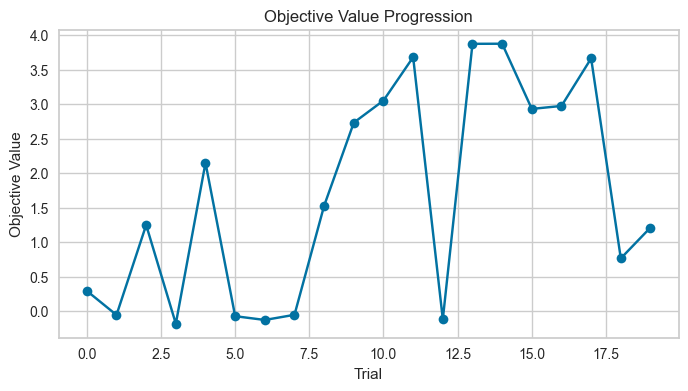

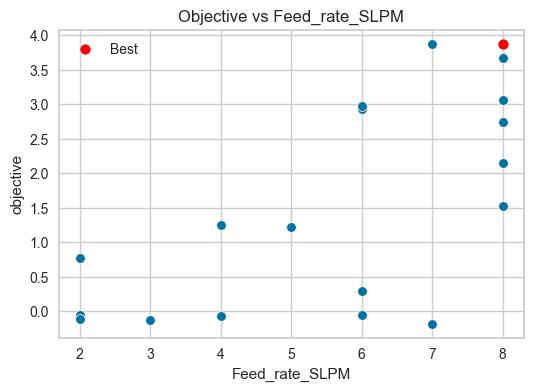

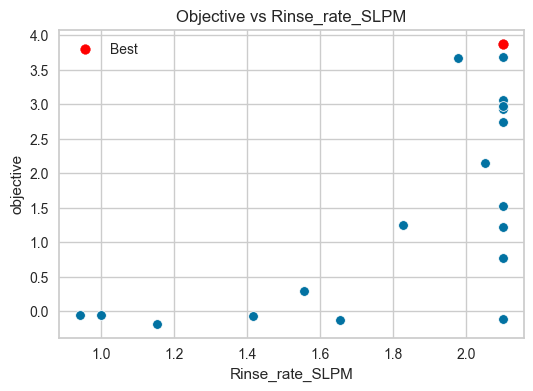

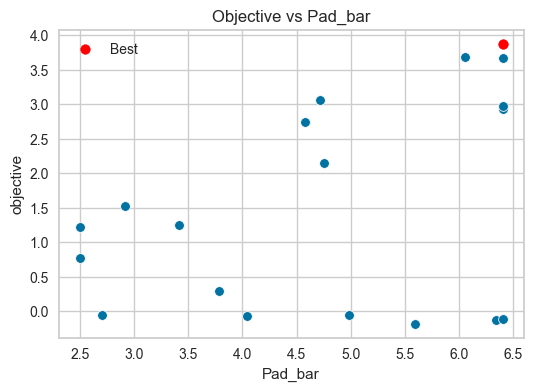

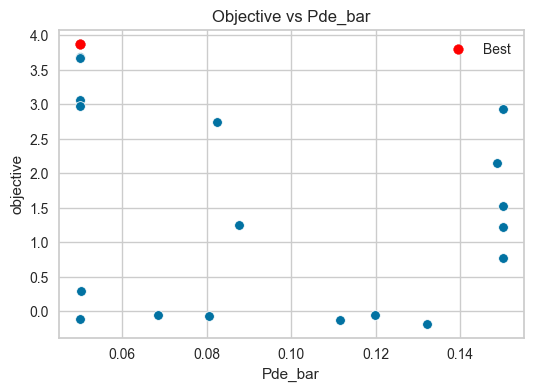

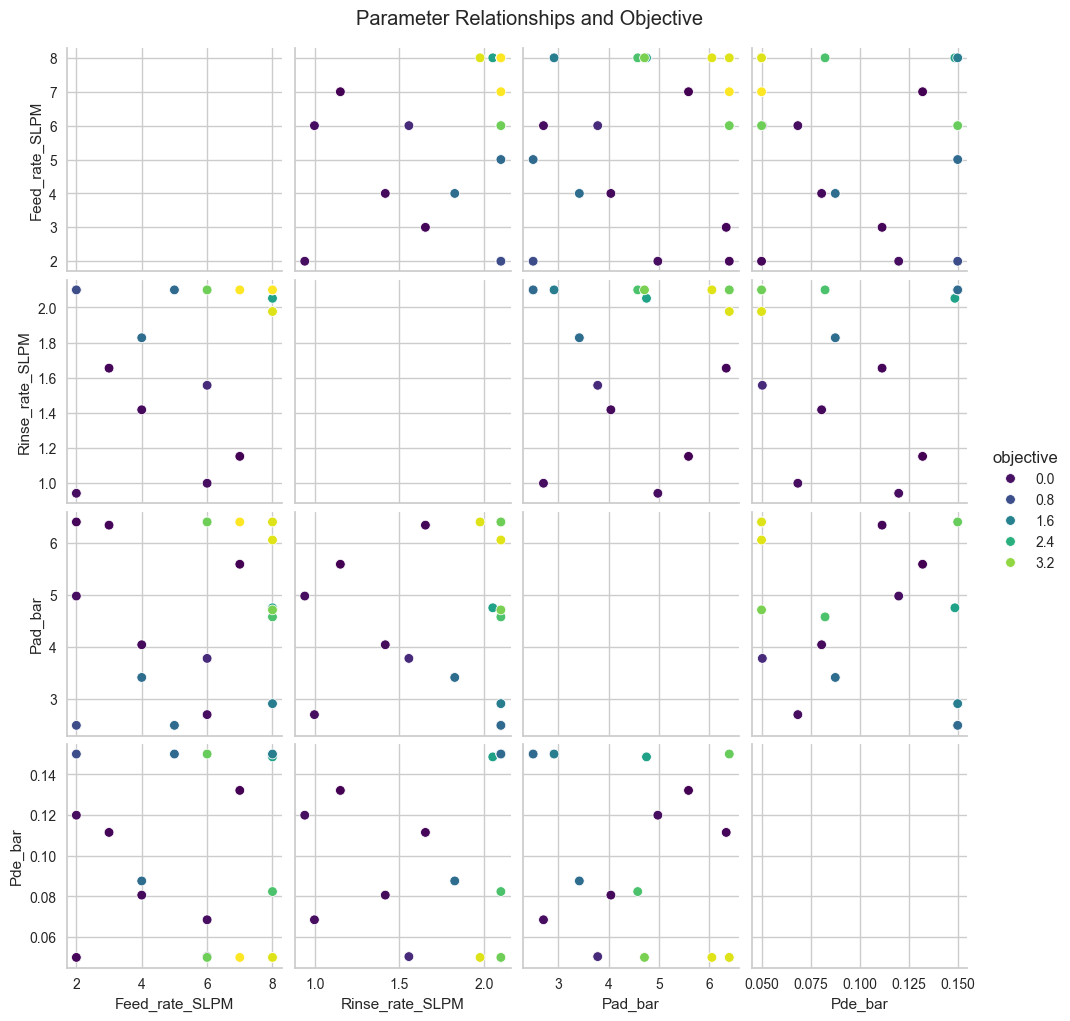

In [11]:
import seaborn as sns

import matplotlib.pyplot as plt

# 1. Objective 값의 변화 추이
objective_values = [trial.objective_mean for trial in experiment.trials.values()]
plt.figure(figsize=(8,4))
plt.plot(objective_values, marker='o')
plt.xlabel('Trial')
plt.ylabel('Objective Value')
plt.title('Objective Value Progression')
plt.show()

# 2. 파라미터별 Objective 값 분포
results = []
for trial in experiment.trials.values():
    params = trial.arm.parameters
    obj = trial.objective_mean
    params['objective'] = obj
    results.append(params)
results_df = pd.DataFrame(results)

param_names = ['Feed_rate_SLPM', 'Rinse_rate_SLPM', 'Pad_bar', 'Pde_bar']
for param in param_names:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=results_df, x=param, y='objective')
    plt.scatter(best_parameters[param], values[0]['objective'], color='red', label='Best', zorder=5)
    plt.title(f'Objective vs {param}')
    plt.legend()
    plt.show()

# 3. Pairplot
sns.pairplot(results_df, vars=param_names, hue='objective', palette='viridis')
plt.suptitle('Parameter Relationships and Objective', y=1.02)
plt.show()